In [319]:
import dateutil.parser
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
%matplotlib inline


In [244]:
df = pd.read_json('tweets.json',lines = True)

In [245]:
print(df.columns)

Index(['conversation_id', 'created_at', 'date', 'gif_thumb', 'gif_url',
       'has_parent_tweet', 'hashtags', 'id', 'is_quote_status', 'is_reply_to',
       'likes_count', 'link', 'location', 'mentions', 'name', 'photos',
       'place', 'quote_id', 'quote_url', 'replies', 'replies_count', 'retweet',
       'retweets_count', 'tags', 'time', 'timezone', 'tweet', 'urls',
       'user_id', 'username', 'video_thumb', 'video_url'],
      dtype='object')


In [246]:
df.head(5)

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
0,1071507278875033600,2018-12-08 20:50:17,2018-12-08,,,0,[#balancetonporc],1071507278875033600,0,0,...,0,[],21:50:17,CET,Un livreur de pizza qui demande clairement des...,[],777095708692324353,hllelea,,
1,1071495065514721280,2018-12-08 20:01:45,2018-12-08,,,0,[#balancetonporc],1071495065514721280,0,0,...,0,[],21:01:45,CET,J'ai ajouté une vidéo à une playlist @YouTube ...,[http://youtu.be/QYAYnGu_iaw?a],830093777591234560,chouchoue_,,
2,1071483541286993920,2018-12-08 19:15:58,2018-12-08,,,0,[#balancetonporc],1071483541286993920,0,0,...,0,[],20:15:58,CET,#balancetonporc https://www.sudouest.fr/2018/...,[https://www.sudouest.fr/2018/09/05/il-photogr...,882276333291786240,sweetieoparadis,,
3,1071481275528167424,2018-12-08 19:06:57,2018-12-08,,,0,[#balancetonporc],1071481275528167425,0,0,...,0,[],20:06:57,CET,Salut la twitosphère #balancetonporc,[],1042521930849570816,duhippolyte,,
4,1071468524571451392,2018-12-08 18:16:17,2018-12-08,,,0,"[#balancetonporc, #balanceta2000]",1071468524571451392,0,0,...,0,[],19:16:17,CET,Après #balancetonporc il y a #balanceta2000 @L...,[],1065703994,alex____torres_,,


In [259]:
df['timedate'] = list(map(lambda el: el[:10]+' ',list(map(str,df.loc[:,'date'])))) + df.loc[:,'time']

In [260]:
df['timedate'] = df.loc[:,'timedate'].apply(lambda t: dateutil.parser.parse(t))

In [ ]:
# Sets index of dataframe to datetime in order to perform time series analysis

df = df.set_index('timedate') 

We use pandas implementation DataFrame.rolling(window).mean() to smooth the original timeseries in order to identify trends. The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [323]:
tmp = [('second',0),('minute',1),('hour',2),('day',3),('month',4),('year',5)]
time_to_num = dict(tmp)

In [324]:
# A more efficient way to do this would be to ask for an integer input, i.e. 1-seconds, 2-minutes, 3-hour etc
# Then, we can find the occurrences of : and take the necessary substring
# Need to find a way to look for indices of a character with multiple occurrences

def countby_upto(t,df):
    df1 = df.copy()
    df1['timedate'] = list(map(lambda el: el[:-3 * time_to_num[t]],list(map(str,df1.index))))
    return df1.groupby(df1['timedate']).size().reset_index().rename(columns = {0:'count'}).set_index('timedate')

In [275]:
df1 = countby_upto('hour',df)

In [316]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

A low smoothing factor means that our smoothed (detrended) data will have a high variance, while a high smoothing factor will result in a low variance, high bias, but it will enable us to better analyze a spike. A smoothing factor of 1 will result in the graph itself.

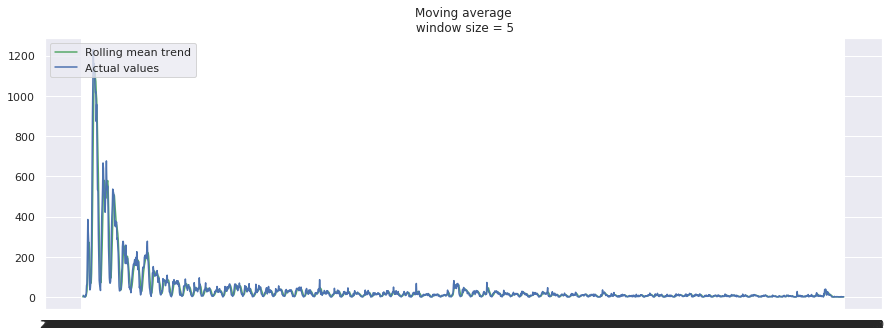

In [308]:
# Low smoothing factor, High variance
plotMovingAverage(df1,5)

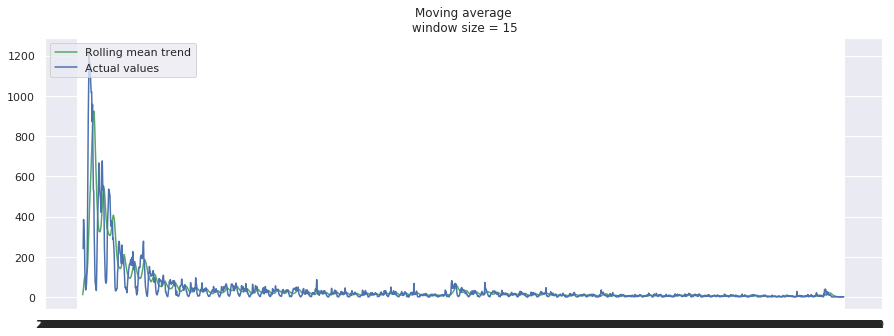

In [283]:
# High Smoothing factor, Low variance, high bias
plotMovingAverage(df1,15)

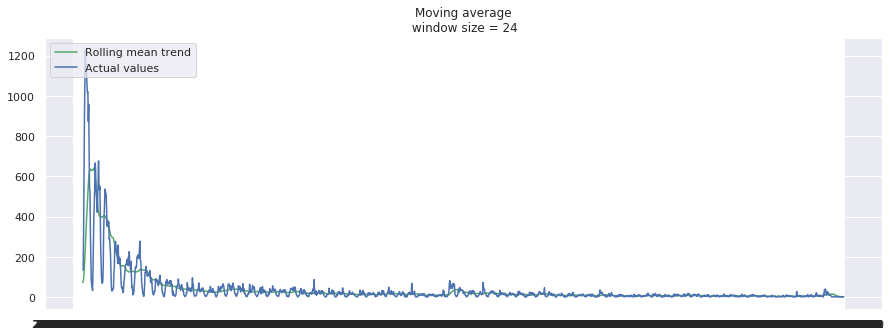

In [284]:
# Get the daily trend
plotMovingAverage(df1,24)

From the above graph, we can observe that the data follows the expected daily trend, i.e., the smoothed data almost perfectly fits our normal data. We can also plot the confidence interval, to see how confident we should be in the correctness of our smoothed data.

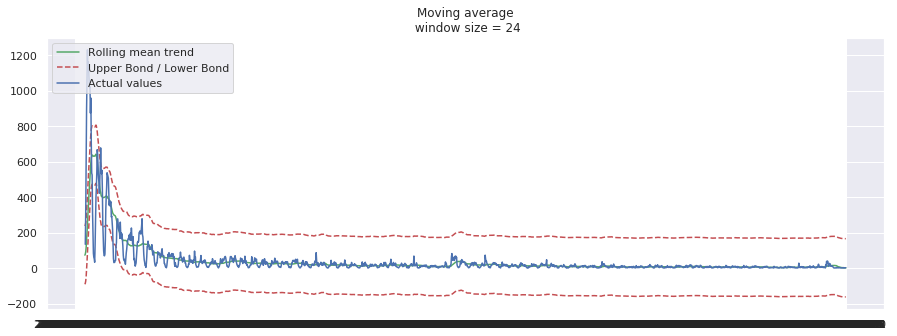

In [320]:
plotMovingAverage(df1,24,plot_intervals = True)

In order to detect deviations from the expected trend, we set plot_anomalies to true 

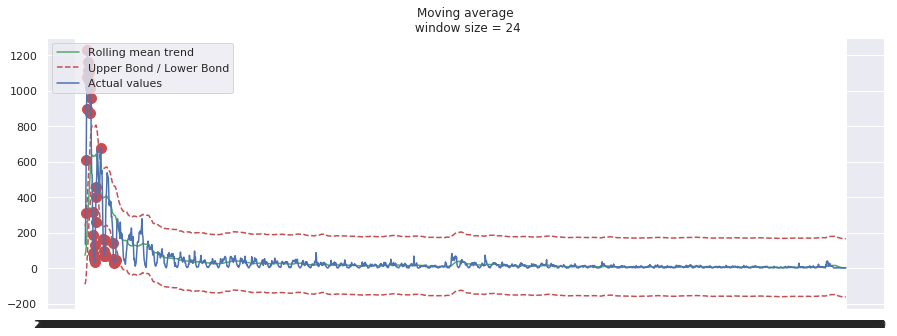

In [321]:
# Detect anomalies

plotMovingAverage(df1,24,plot_intervals = True, plot_anomalies = True)

The downside of this model is that it doesn't account for the seasonality in our data. In the case of time series, a weighted window average would be better, in order to give more weights to the recent observations.

In [322]:
# Same as rolling window, but we take the weighted average

def weighted_average(series, weights):
    
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [335]:
# Assign higher value to the initial weights
weights = [0.05] * 20 
weighted_average(df1,weights)

1.7000000000000008

Another method that we can use is the exponential smoothing method which weighs all the values with a factor alpha that decreases with time

In [352]:
def exponential_smoothing(series, alpha):
    result = [series.values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.values[n] + (1 - alpha) * result[n-1])
    return result    

The code below tests the exponential_smoothing method with different values of alpha

In [337]:
def plotExponentialSmoothing(series, alphas):

    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

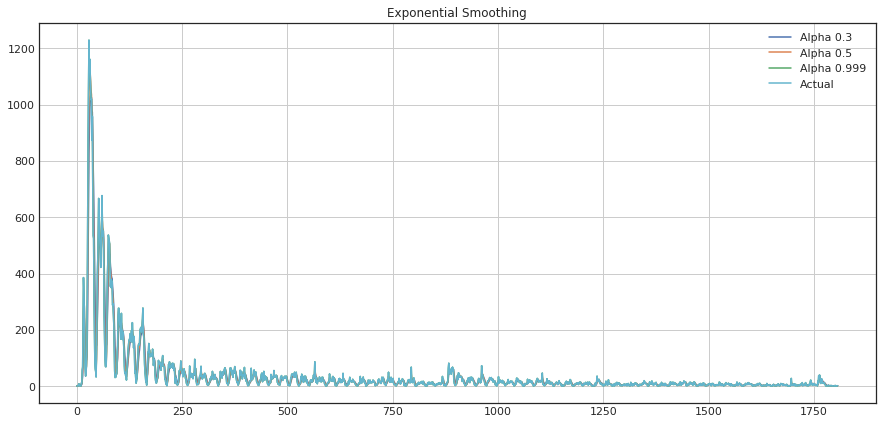

In [362]:
plotExponentialSmoothing(df1,[0.3,0.5,0.999])

In [371]:
%%latex
The exponential smoothing method only works when certain trends are observed in the data. In order to have a model that accounts for the periodicity of the data, we need to implement the Holt-Winters model according to the formulas below:
$S_t = \frac{y_t}{I_{T-L}} +(1-\alpha) (S_{t-1} + b_{t-1}$ for the general smoothing.
$b_t = \gamma (S_t - S_{t-1}) + (1 - \gamma) b_{t-1}$ for trend smoothing and
$\beta \frac{S_t}{y_t} + (1-\beta(=) I_{t-L}$ for seasonal smoothing.

<IPython.core.display.Latex object>

In [372]:
# I will determine the parameters for Holt Winters using Machine Learning